In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.61s/it]


In [8]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
29,True,True,False,False,rrr,1.0,tyield10,4,29,dsr_n_n_b_r,531.069421,-0.031758,0.964743,-16690.677138
28,True,True,False,False,rrr,1.0,tyield10,3,28,dsr_n_n_b_r,531.069421,-0.031758,0.964743,-16690.677138
27,True,True,False,False,rrr,1.0,tyield10,2,27,dsr_n_n_b_r,531.069421,-0.031758,0.964743,-16690.677138
26,True,True,False,False,rrr,1.0,tyield10,1,26,dsr_n_n_b_r,531.069421,-0.031758,0.964743,-16690.677138
25,True,True,False,False,rrr,1.0,tyield10,0,25,dsr_n_n_b_r,531.069421,-0.031758,0.964743,-16690.677138
17,True,True,False,False,rrr,1.0,tyield1,2,17,dsr_n_n_b_r,530.983564,-0.031684,0.964826,-16727.425420
16,True,True,False,False,rrr,1.0,tyield1,1,16,dsr_n_n_b_r,530.983564,-0.031684,0.964826,-16727.425420
19,True,True,False,False,rrr,1.0,tyield1,4,19,dsr_n_n_b_r,530.983564,-0.031684,0.964826,-16727.425420
18,True,True,False,False,rrr,1.0,tyield1,3,18,dsr_n_n_b_r,530.983564,-0.031684,0.964826,-16727.425420
15,True,True,False,False,rrr,1.0,tyield1,0,15,dsr_n_n_b_r,530.983564,-0.031684,0.964826,-16727.425420


In [36]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
0,dsr_n_n_b_r,True,True,False,False,rrr,1.0,tyield10,4,29,531.069421,-0.031758,0.964743,-16690.677138


In [10]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [11]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [37]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [38]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,AKAM,0.375760,1.0,1.227848,0,Information Technology,Akamai
1,2001,2001-01-03,AKAM,0.461797,1.0,0.861031,0,Information Technology,Akamai
2,2001,2001-01-04,EIX,0.422816,1.0,0.959070,0,Utilities,Edison International
3,2001,2001-01-05,EIX,0.567535,1.0,1.163919,0,Utilities,Edison International
4,2001,2001-01-08,EIX,0.588652,1.0,0.927500,0,Utilities,Edison International
...,...,...,...,...,...,...,...,...,...
107642,2023,2023-07-14,RCL,0.006664,1.0,1.010229,19,Consumer Discretionary,Royal Caribbean Group
107643,2023,2023-07-20,UAL,0.000374,1.0,1.018384,19,Industrials,United Airlines Holdings
107644,2023,2023-07-21,GIS,0.002907,1.0,1.003247,19,Consumer Staples,General Mills
107645,2023,2023-07-25,BIIB,0.009294,1.0,0.981281,19,Health Care,Biogen


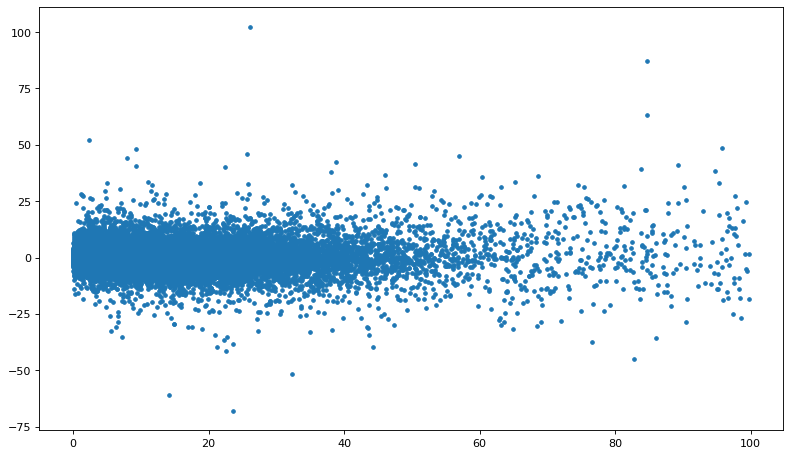

In [39]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [40]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,AKAM,0.375760,1.0,1.227848,0,Information Technology,Akamai
5630,2001,2001-01-02,EIX,0.183717,1.0,0.816667,1,Utilities,Edison International
11258,2001,2001-01-02,EQIX,0.155365,1.0,1.016854,2,Real Estate,Equinix
16882,2001,2001-01-02,APH,0.155040,1.0,1.026103,3,Information Technology,Amphenol
22493,2001,2001-01-02,WDC,0.072970,1.0,1.216169,4,Information Technology,Western Digital
28089,2001,2001-01-02,IBM,0.065129,1.0,1.115670,5,Information Technology,IBM
33660,2001,2001-01-02,INCY,0.059867,1.0,1.022163,6,Health Care,Incyte
39210,2001,2001-01-02,NLOK,0.056231,1.0,1.171335,7,Information Technology,NortonLifeLock
44723,2001,2001-01-02,ADI,0.053380,1.0,1.159574,8,Information Technology,Analog Devices
50209,2001,2001-01-02,ODFL,0.051237,1.0,1.017769,9,Industrials,Old Dominion


In [41]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
18857,2008,2008-12-04,HIG,0.261279,1.0,2.023578,3,Financials,Hartford (The)
13199,2008,2008-10-10,MS,0.846386,1.0,1.869835,2,Financials,Morgan Stanley
386,2002,2002-07-24,CNP,0.846646,1.0,1.629630,0,Utilities,CenterPoint Energy
75303,2016,2016-04-21,AMD,0.022778,1.0,1.522901,13,Information Technology,AMD
2019,2009,2009-02-05,RF,0.957400,1.0,1.484099,0,Financials,Regions Financial Corporation
24548,2009,2009-04-02,MGM,0.093536,1.0,1.480892,4,Consumer Discretionary,MGM Resorts
45095,2002,2002-07-25,JCI,0.256100,1.0,1.458182,8,Industrials,Johnson Controls
84143,2008,2008-11-21,CBRE,0.569798,1.0,1.449857,15,Real Estate,CBRE Group
71092,2020,2020-11-03,BIIB,0.080019,1.0,1.439739,12,Health Care,Biogen
464,2002,2002-11-14,ALGN,0.387692,1.0,1.424460,0,Health Care,Align Technology


In [42]:
ledger["actual_returns"].mean()

1.0012540509988777

In [43]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5123877116872741

In [44]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [45]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-02,1.227848,0.816667,1.016854,1.026103,1.216169,1.115670,1.022163,1.171335,...,1.015488,1.261704,1.056669,1.184727,0.992080,1.013374,1.009032,1.065395,1.000000,1.000000
1,2001,2001-01-03,0.861031,0.953728,1.000000,0.921757,0.927684,1.013798,1.037187,0.996573,...,0.939091,1.035330,0.877551,0.898882,1.042992,0.987424,0.956514,1.005229,0.956091,1.155350
2,2001,2001-01-04,0.959070,0.845011,1.104972,0.879457,0.938835,0.931034,0.909152,0.907330,...,0.896390,0.939355,0.895031,0.981447,0.874642,0.958140,0.907821,1.018896,0.822989,0.943925
3,2001,2001-01-05,1.163919,0.985000,0.743300,1.022605,0.925212,1.026099,0.929573,0.863336,...,1.032576,1.038571,0.969191,1.053461,0.966231,1.042827,1.058605,1.011662,0.978374,1.065973
4,2001,2001-01-08,0.927500,0.971831,0.956140,0.994115,1.036667,1.021277,1.096386,1.096566,...,0.998864,1.100413,1.047689,1.005044,1.015869,0.994795,0.923514,0.981673,1.014719,1.023299
5,2001,2001-01-09,1.217391,1.112083,1.048073,1.180258,1.040193,1.036996,1.010782,1.034938,...,0.918490,1.024194,1.052064,0.976299,1.101268,1.076668,1.029412,0.979167,1.086632,1.072145
6,2001,2001-01-10,1.274286,1.242997,1.032784,0.933333,1.016104,1.015697,1.009660,1.018373,...,1.007222,0.993892,0.992908,1.050492,1.002741,0.955614,1.048612,1.025487,0.981258,1.055906
7,2001,2001-01-11,0.970476,1.012394,1.047418,1.049521,1.061128,1.083429,1.190722,1.064511,...,0.996139,0.972655,1.017715,0.961780,1.051677,1.001967,1.005295,0.965161,1.006331,0.981580
8,2001,2001-01-12,0.938469,1.093058,0.999002,1.006711,0.989402,1.008723,0.974368,1.082251,...,1.037493,1.003876,1.027027,0.997391,1.007718,0.978907,0.968121,0.989277,1.026912,1.006033
9,2001,2001-01-16,0.928056,0.907961,0.981359,0.996690,0.967238,0.999144,1.054955,1.051494,...,0.995020,1.029039,0.978621,1.008990,1.096525,1.050526,1.023391,1.010898,0.971115,0.971761


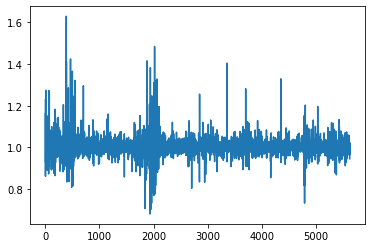

In [46]:
plt.plot(portfolio[0])

In [47]:
positions = 20

In [48]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [49]:
anas.naming

'date'

In [50]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
5620,8312.115416,2.464627,97.013428,1.702364,454.705928,42.248910,98.284028,5.027275,108.481869,35.923892,...,36.270261,8.431758,34.451545,159.349219,2023,2023-07-11,538.496710,1.004866,13760.70,6.004163
5621,8337.555675,2.449242,95.436550,1.706939,458.993317,41.683162,102.920145,5.057551,107.321041,35.857129,...,37.118985,8.505733,34.451545,159.349219,2023,2023-07-12,540.358264,1.003428,13918.96,6.073216
5622,8392.350079,2.510662,95.900797,1.760038,492.227406,42.083057,103.662220,5.229278,106.735152,36.096462,...,37.253582,8.501789,34.512301,156.925351,2023,2023-07-13,545.697762,1.013905,14138.57,6.169037
5623,8460.688561,2.469262,95.405781,1.759627,491.810990,42.032742,102.777703,5.163048,106.580064,35.915833,...,37.450994,8.357834,34.669516,158.530561,2023,2023-07-14,548.979517,0.996188,14113.70,6.158186
5624,8595.732499,2.469262,96.426598,1.845909,501.960718,42.342711,103.993802,5.152264,106.599517,37.085413,...,37.450994,8.357834,34.669516,158.530561,2023,2023-07-18,556.904625,1.008024,14353.64,6.262878
5625,8714.670279,2.527760,98.107284,1.859428,477.512979,42.065035,105.582639,5.181963,108.422464,37.924323,...,37.450994,8.357834,34.669516,158.530561,2023,2023-07-19,561.989114,1.006845,14358.02,6.264789
5626,8714.670279,2.545003,99.853062,1.872694,477.037774,42.122145,106.021098,5.215697,109.642390,37.531465,...,37.307268,8.377324,35.263527,161.445035,2023,2023-07-20,563.695068,1.007023,14063.31,6.136199
5627,8393.603480,2.644402,100.147788,1.880709,483.178505,43.475412,105.024781,5.287694,106.019625,37.138840,...,37.383192,8.299995,35.146287,161.969207,2023,2023-07-21,547.663195,0.999467,14032.81,6.122891
5628,8583.289434,2.711492,99.644026,1.929283,484.589657,43.432153,103.789628,5.435588,108.474267,37.655935,...,37.811652,8.452350,35.023074,158.937266,2023,2023-07-25,557.917653,1.009266,14144.56,6.171651
5629,8109.074548,2.670701,97.058777,1.895197,470.511842,44.603169,107.141475,5.399753,107.842574,38.300118,...,37.287887,8.249444,35.675190,156.211307,2023,2023-07-26,531.069421,0.988214,14127.28,6.164111


In [51]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [52]:
cash_analysis["cash"].sum()

2784.518095177775

In [53]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.069431,NaN,NaN,0.000000,0.000000
1,0.976931,1.000000,0.976931,0.000000,0.000000
2,0.927593,0.976931,0.906195,0.000000,0.000000
3,0.992294,0.927593,0.920445,0.000000,0.000000
4,1.003334,0.992294,0.995602,0.000000,0.000000
...,...,...,...,...,...
5625,1.006845,1.000000,1.006845,0.684489,2782.942941
5626,1.007023,1.000000,1.007023,0.702277,2783.645218
5627,0.999467,1.000000,0.999467,0.000000,2783.645218
5628,1.009266,0.999467,1.008729,0.872878,2784.518095


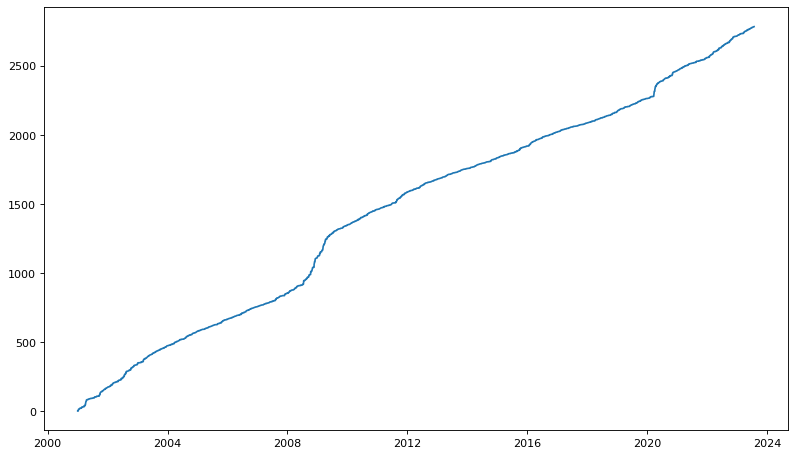

In [54]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

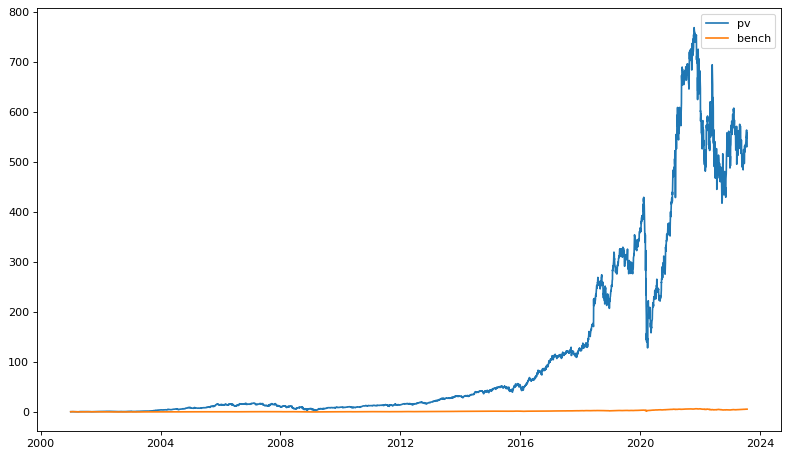

In [55]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [56]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
0,1.227848,0.816667,1.016854,1.026103,1.216169,1.115670,1.022163,1.171335,1.159574,1.017769,...,1.009032,1.065395,1.000000,1.000000,2001,2001-01-02,1.069431,1.069431,2291.86,1.000000
1,1.057215,0.778878,1.016854,0.945817,1.128221,1.131064,1.060175,1.167321,1.186444,0.966110,...,0.965153,1.070966,0.956091,1.155350,2001,2001-01-03,1.043657,0.976931,2616.69,1.141732
2,1.013943,0.658160,1.123596,0.831806,1.059213,1.053060,0.963860,1.059145,1.094217,0.885051,...,0.876187,1.091204,0.786853,1.090564,2001,2001-01-04,0.970381,0.927593,2566.83,1.119977
3,1.180147,0.648288,0.835168,0.850609,0.979996,1.080544,0.895978,0.914398,1.101915,0.851711,...,0.927536,1.103929,0.769836,1.162512,2001,2001-01-05,0.961966,0.992294,2407.65,1.050522
4,1.094587,0.630026,0.798538,0.845603,1.015929,1.103534,0.982337,1.002698,1.009530,0.804153,...,0.856592,1.083698,0.781167,1.189598,2001,2001-01-08,0.965714,1.003334,2395.92,1.045404
5,1.332540,0.700641,0.836927,0.998030,1.056763,1.144360,0.992928,1.037731,1.098294,0.857509,...,0.881786,1.061121,0.848841,1.275421,2001,2001-01-09,1.019256,1.057566,2441.30,1.065205
6,1.698037,0.870895,0.864364,0.931494,1.073781,1.162324,1.002520,1.056797,1.176132,0.871833,...,0.924651,1.088166,0.832931,1.346724,2001,2001-01-10,1.058168,1.037247,2524.18,1.101367
7,1.647904,0.881689,0.905351,0.977623,1.139419,1.259295,1.193722,1.124972,1.169522,0.872925,...,0.929547,1.050255,0.838205,1.321918,2001,2001-01-11,1.077890,1.021777,2640.57,1.152152
8,1.546507,0.963738,0.904447,0.984185,1.127343,1.270281,1.163124,1.217502,1.155352,0.883702,...,0.899914,1.038993,0.860763,1.329893,2001,2001-01-12,1.081737,1.006748,2626.50,1.146012
9,1.435245,0.875037,0.887587,0.980927,1.090409,1.269193,1.227044,1.280196,1.123042,0.837899,...,0.920964,1.050316,0.835899,1.292338,2001,2001-01-16,1.078628,0.997149,2618.55,1.142544


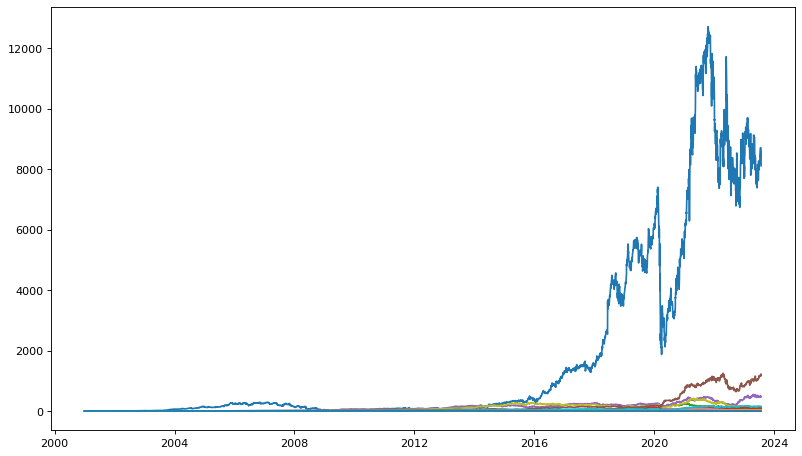

In [57]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [58]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Health Care,2010.569028,0.070989,1.0,1.001859,8.905677
Energy,2013.444376,0.078703,1.0,1.001805,9.357800
Information Technology,2011.124504,0.078026,1.0,1.001329,8.561376
Consumer Discretionary,2012.439519,0.075243,1.0,1.001301,8.869051
Financials,2011.514206,0.083966,1.0,1.001165,10.086543
Real Estate,2011.255328,0.077857,1.0,1.001074,10.283011
Consumer Staples,2011.874447,0.045786,1.0,1.001004,10.050375
Industrials,2011.773094,0.070886,1.0,1.000997,9.688539
Communication Services,2013.251912,0.072199,1.0,1.000693,8.682506


In [59]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                      
2008 2008-12-04 HIG    Hartford (The)                     0.261279   
     2008-10-10 MS     Morgan Stanley                     0.846386   
2002 2002-07-24 CNP    CenterPoint Energy                 0.846646   
2016 2016-04-21 AMD    AMD                                0.022778   
2009 2009-02-05 RF     Regions Financial Corporation      0.957400   
     2009-04-02 MGM    MGM Resorts                        0.093536   
2002 2002-07-25 JCI    Johnson Controls                   0.256100   
2008 2008-11-21 CBRE   CBRE Group                         0.569798   
2020 2020-11-03 BIIB   Biogen                             0.080019   
2002 2002-11-14 ALGN   Align Technology                   0.387692   
2008 2008-07-15 UAL    United Airlines Holdings           0.504227   
2002 2002-07-26 AES    AES Corporation                    0.892373   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals             0.092164   
2008 2008-07-16 HBAN   Huntington National Bank           0.223922   
2020 2020-03-23 BBWI   Bath & Body Works, Inc.            0.837628   
2008 2008-10-10 PRU    Prudential Financial               0.947460   
2020 2020-04-03 CZR    Caesars Entertainment              0.380506   
2003 2003-01-06 EQIX   Equinix                            0.460433   
2002 2002-06-12 JCI    Johnson Controls                   0.686787   
2008 2008-10-27 AIG    American International Group       0.604118   
     2008-11-21 KIM    Kimco Realty                       0.652709   
2001 2001-04-06 AMZN   Amazon                             0.110197   
2020 2020-03-23 MGM    MGM Resorts                        0.953139   
2009 2009-04-09 HBAN   Huntington National Bank           0.049708   
2018 2018-06-12 ENPH   Enphase                            0.186580   
2009 2009-04-07 LNC    Lincoln Financial                  0.258307   
2001 2001-06-28 ILMN   Illumina                           0.116333   
2003 2003-03-14 ILMN   Illumina                           0.322444   
2009 2009-02-19 HBAN   Huntington National Bank           0.745420   
     2009-02-25 LVS    Las Vegas Sands                    0.434170   

                                                      dately_delta_sign  \
year date       ticker Security                                           
2008 2008-12-04 HIG    Hartford (The)                               1.0   
     2008-10-10 MS     Morgan Stanley                               1.0   
2002 2002-07-24 CNP    CenterPoint Energy                           1.0   
2016 2016-04-21 AMD    AMD                                          1.0   
2009 2009-02-05 RF     Regions Financial Corporation                1.0   
     2009-04-02 MGM    MGM Resorts                                  1.0   
2002 2002-07-25 JCI    Johnson Controls                             1.0   
2008 2008-11-21 CBRE   CBRE Group                                   1.0   
2020 2020-11-03 BIIB   Biogen                                       1.0   
2002 2002-11-14 ALGN   Align Technology                             1.0   
2008 2008-07-15 UAL    United Airlines Holdings                     1.0   
2002 2002-07-26 AES    AES Corporation                              1.0   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals                       1.0   
2008 2008-07-16 HBAN   Huntington National Bank                     1.0   
2020 2020-03-23 BBWI   Bath & Body Works, Inc.                      1.0   
2008 2008-10-10 PRU    Prudential Financial                         1.0   
2020 2020-04-03 CZR    Caesars Entertainment                        1.0   
2003 2003-01-06 EQIX   Equinix                                      1.0   
2002 2002-06-12 JCI    Johnson Controls                             1.0   
2008 2008-10-27 AIG    American International Group                 1.0   
     2008-11-21 KIM    Kimco Realty                                 1.0   
2001 2001-04-06 AMZN   Amazon                                       1.0   
2020 2020-03-

In [60]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.000000,1.056669,1.000000,1.000000,1.138596,1.009206,1.013401,1.145853,1.000000,1.016854,0.816667
1,4004001,2252-06-29 23:17:13.297436672,1.000000,0.949821,1.000000,1.000000,1.138596,0.997999,1.018700,1.127367,1.000000,1.016854,0.716667
2,8012006001,2159-09-27 04:21:44.589074432,1.000000,0.892219,1.000000,1.000000,1.033642,0.902007,1.018700,1.017453,1.000000,1.123596,0.706971
3,16032024008001,1970-01-01 00:00:00.000000000,1.000000,0.894214,1.058605,1.000000,1.077910,0.853649,1.018700,1.032422,1.000000,1.106742,0.822856
4,32080080040010001,1970-01-01 00:00:00.000000000,1.000000,0.980403,1.058605,1.000000,1.072299,0.872533,0.940783,1.032918,1.000000,1.044944,0.763199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,1970-01-01 00:00:00.000000000,3.146134,198.388297,4.951012,11.915077,16.581628,76.301750,32.942796,188.559397,3.696117,1.778310,4.314371
5626,0,1970-01-01 00:00:00.000000000,3.165960,198.635180,4.977408,11.915077,16.487492,77.442921,33.548426,188.939399,3.696117,1.780622,4.314371
5627,0,1970-01-01 00:00:00.000000000,3.161223,197.220244,4.977520,11.915077,16.715084,76.389769,33.548426,184.930200,3.696117,1.825412,4.314371
5628,0,1970-01-01 00:00:00.000000000,3.193085,199.637600,4.977520,11.915077,16.889963,74.959810,33.548426,184.373078,3.696117,1.866877,4.314371
